In [1]:
# starting code
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### Architecture of a classification neural network

| Hyperparameter                    | Binary Classification                                                                                        | Multiclass classification                                                                                                        |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------- |
| Input layer shape (in_features)   | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification                                                                                                    |
| Hidden layer(s)                   | Problem specific, minimum = 1, maximum = unlimited                                                           | Same as binary classification                                                                                                    |
| Neurons per hidden layer          | Problem specific, generally 10 to 512                                                                        | Same as binary classification                                                                                                    |
| Output layer shape (out_features) | 1 (one class or the other)                                                                                   | 1 per class (e.g. 3 for food, person or dog photo)                                                                               |
| Hidden layer activation           | Usually ReLU (rectified linear unit) but can be many others                                                  | Same as binary classification                                                                                                    |
| Output activation                 | Sigmoid (torch.sigmoid in PyTorch)                                                                           | Softmax (torch.softmax in PyTorch)                                                                                               |
| Loss function                     | Binary crossentropy (torch.nn.BCELoss in PyTorch)                                                            | [Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Optimizer                         | SGD (stochastic gradient descent), Adam (see torch.optim for more options)                                   | Same as binary classification                                                                                                    |


### Preparing data

In [2]:
from sklearn.datasets import make_circles

# Make 10000 samples 
n_samples = 10000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=13) # keep random state so we get the same values

In [3]:
# 2 features per 1 y value
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.29995149  0.73901664]
 [-0.57678771  0.77565796]
 [ 0.96338061 -0.25824735]
 [ 0.97059622  0.20609374]
 [-0.77483082  0.35649152]]

First 5 y labels:
[1 0 0 0 1]


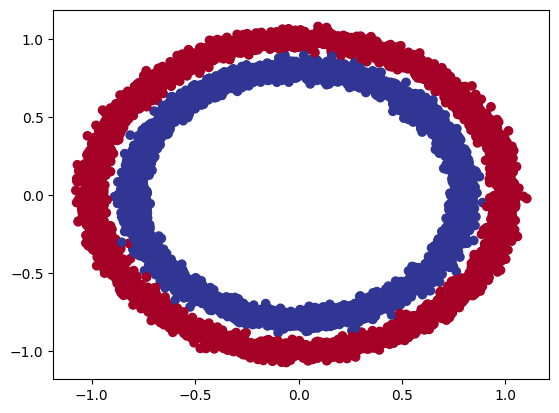

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### Prepare train and test data

In [5]:
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, 
                                                    y_tensor, 
                                                    stratify=y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=13) # make the random split reproducible

print(len(X_train), len(X_test), len(y_train), len(y_test))
print(y_train.sum()/len(y_train), y_test.sum()/len(y_test))

8000 2000 8000 2000
tensor(0.5000) tensor(0.5000)


In [6]:
# Getting input and output shapes correct
print(X_train.shape, y_train.shape)

torch.Size([8000, 2]) torch.Size([8000])


### Defining the model

In [7]:
class CircleClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Create 2 nn.Linear layers, first layer takes in shape of X (i.e. 2), layer 2 output into shape of y
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        layer_1_output = self.layer_1(x)
        return self.layer_2(layer_1_output)

model_0 = CircleClassificationModel()
model_0.to(device)

CircleClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
# logits → nn.BCEWithLogitsLoss
# logits → sigmoid → nn.BCELoss
# in this example, we have not applied a sigmoid transformation, so use BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [9]:
# Evaluation metric

# Calculate accuracy (a classification metric)
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Model training

In [10]:
epochs = 1000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# pytorch training loop
def training(model, epochs):
    for epoch in range(epochs):
        ### MODEL TRAINING

        # 0. Put model in training mode
        model.train()
        
        # 1. Forward pass
        y_train_logits = model(X_train).squeeze() # the output has shape (n, 1), squeeze to turn it into just shape (n)
        y_train_pred = torch.round(torch.sigmoid(y_train_logits)) # use sigmoid to get probabilities, then rounding to get 0s & 1s

        # 2. Calculate loss & accuracy
        acc = accuracy_fn(y_train_pred, y_train)
        loss = loss_fn(y_train_logits, y_train)
        
        # 3. zero gradients - optimizer gradients are set to zero so they can be recalcualted for the specific training step
        optimizer.zero_grad()

        # 4. Backpropagation on loss -  calculate loss gradients
        loss.backward()

        # 5. Update the parameters (every model parameter with requires_grad = True) with respect to the loss gradients
        optimizer.step()
            
        ### MODEL Testing
        # 0. Put model in evaluation mode
        model.eval()

        # 1. use inference mode to do predictions on test data
        with torch.inference_mode():
            y_test_pred_logits = model(X_test).squeeze()
            y_test_pred = torch.round(torch.sigmoid(y_test_pred_logits))
            test_loss = loss_fn(y_test_pred_logits, y_test) 
            test_accuracy = accuracy_fn(y_test_pred, y_test)

            if epoch % 50 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.item())
                test_loss_values.append(test_loss.item())
                print(f"Step {epoch}: training loss is {loss}, test loss is {test_loss}, training accuracy is {acc}, test accuracy is {test_accuracy}")

training(model=model_0, epochs=epochs)

Step 0: training loss is 0.7102155089378357, test loss is 0.7095651626586914, training accuracy is 50.0, test accuracy is 50.0
Step 50: training loss is 0.6932629942893982, test loss is 0.6934854388237, training accuracy is 53.125, test accuracy is 52.1
Step 100: training loss is 0.6931529641151428, test loss is 0.6933403611183167, training accuracy is 50.5125, test accuracy is 49.9
Step 150: training loss is 0.693132221698761, test loss is 0.6933389902114868, training accuracy is 50.5375, test accuracy is 49.65
Step 200: training loss is 0.6931227445602417, test loss is 0.6933540105819702, training accuracy is 50.4125, test accuracy is 48.949999999999996
Step 250: training loss is 0.6931183934211731, test loss is 0.693370521068573, training accuracy is 50.425, test accuracy is 49.35
Step 300: training loss is 0.693116307258606, test loss is 0.6933844685554504, training accuracy is 50.387499999999996, test accuracy is 49.15
Step 350: training loss is 0.6931153535842896, test loss is 0.

### investigate poor performance

In [11]:
# helper functions from Learn PyTorch for Deep Learning repo - https://github.com/mrdbourke/pytorch-deep-learning 

from helper_functions import plot_predictions, plot_decision_boundary

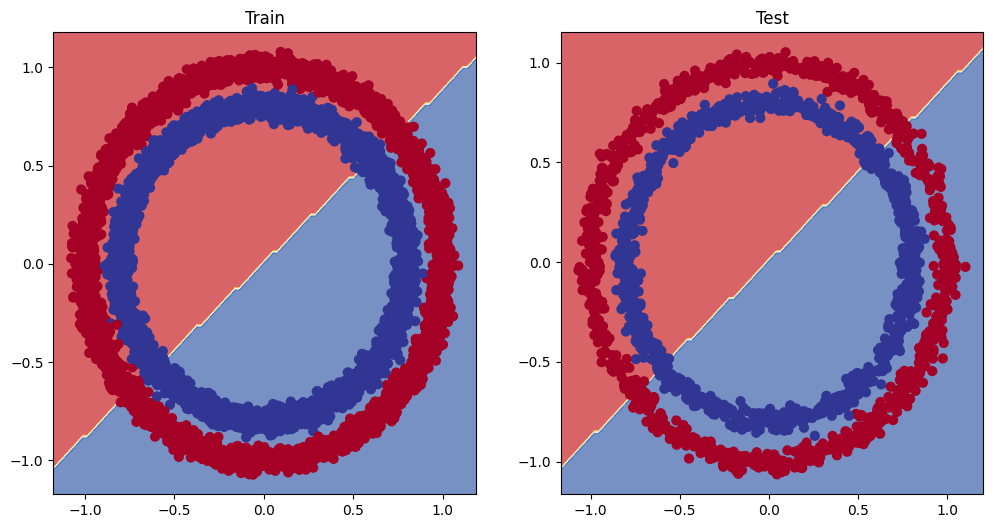

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Model is not performing well due to using only straight lines to fit the data

### Improving model performance

In [13]:
class CircleClassificationModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Create 2 nn.Linear layers, first layer takes in shape of X (i.e. 2), layer 2 output into shape of y
        self.layer_1 = nn.Linear(in_features=2, out_features=10) 
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1) 
        self.relu = nn.ReLU()
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        layer_1_output = self.relu(self.layer_1(x))
        layer_2_output = self.relu(self.layer_2(layer_1_output))
        return self.layer_3(layer_2_output)

model_1 = CircleClassificationModelV2()
model_1.to(device)

# Define loss function
loss_fn = nn.BCEWithLogitsLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [14]:
from torchinfo import summary
summary(model_1, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
CircleClassificationModelV2              [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   30
├─ReLU: 1-2                              [1, 10]                   --
├─Linear: 1-3                            [1, 10]                   110
├─ReLU: 1-4                              [1, 10]                   --
├─Linear: 1-5                            [1, 1]                    11
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [15]:
epochs = 2000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# pytorch training loop
training(model=model_1, epochs=epochs)

Step 0: training loss is 0.7069855332374573, test loss is 0.7056558132171631, training accuracy is 50.0, test accuracy is 50.0
Step 50: training loss is 0.6923831701278687, test loss is 0.6917199492454529, training accuracy is 55.2, test accuracy is 58.45
Step 100: training loss is 0.690811276435852, test loss is 0.6903195977210999, training accuracy is 53.175, test accuracy is 53.65
Step 150: training loss is 0.6888062357902527, test loss is 0.6883805394172668, training accuracy is 56.6125, test accuracy is 57.699999999999996
Step 200: training loss is 0.6873167157173157, test loss is 0.6870719194412231, training accuracy is 58.199999999999996, test accuracy is 59.4
Step 250: training loss is 0.6855013966560364, test loss is 0.6854546666145325, training accuracy is 60.212500000000006, test accuracy is 60.199999999999996
Step 300: training loss is 0.6831504106521606, test loss is 0.6833802461624146, training accuracy is 60.9875, test accuracy is 61.3
Step 350: training loss is 0.680459

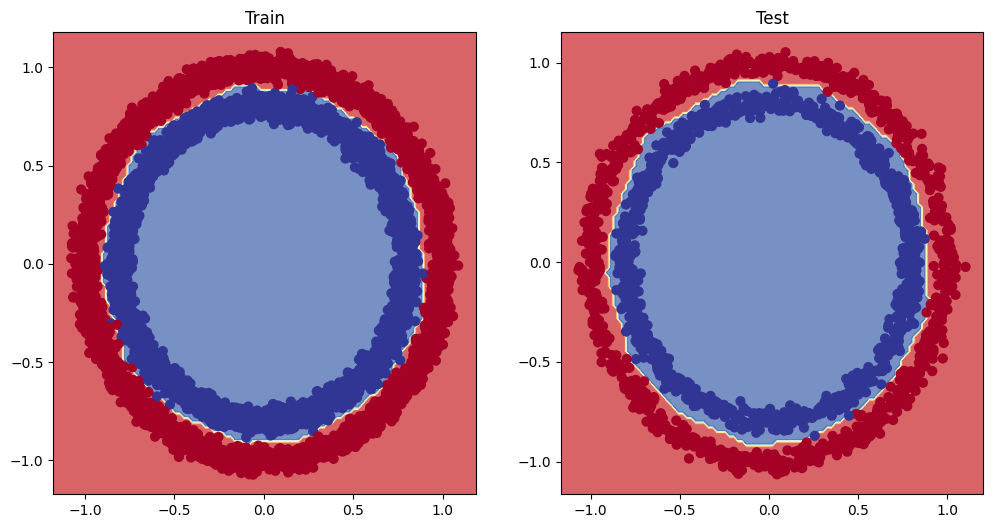

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### multi-class example

[[ 7.29080142 11.13952702]
 [ 4.19833594 -5.81437577]
 [ 6.18470581  5.27969911]
 [ 5.69161781 -4.81287005]
 [ 7.27611978  9.93954161]] [1 0 1 0 1]


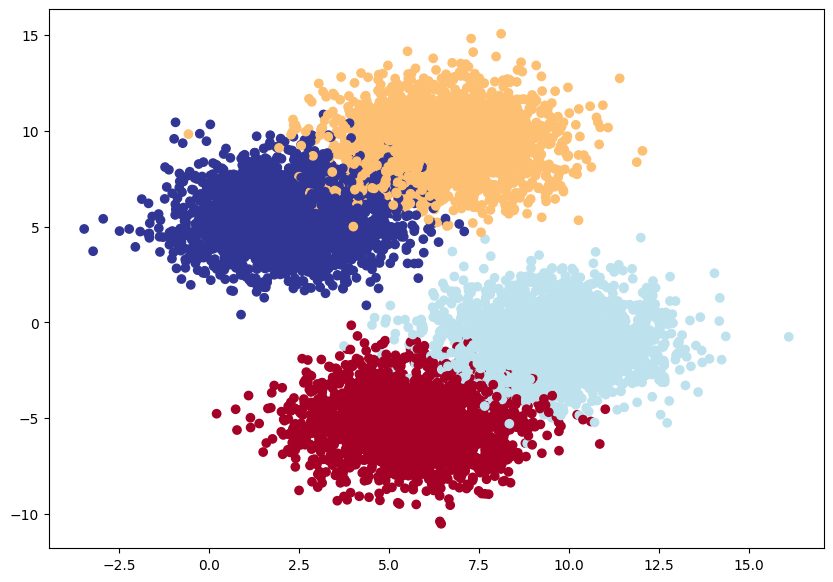

In [17]:
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 13

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=10000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob_tensor = torch.from_numpy(X_blob).type(torch.float)
y_blob_tensor = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob_tensor,
    y_blob_tensor,
    stratify=y_blob_tensor,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [18]:
class MultiClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Create 2 nn.Linear layers, first layer takes in shape of X (i.e. 2), layer 2 output into shape of y
        self.layer_1 = nn.Linear(in_features=NUM_FEATURES, out_features=10) 
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=NUM_CLASSES) # set the final layer to output the same number of classes
        self.relu = nn.ReLU()
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        layer_1_output = self.relu(self.layer_1(x))
        layer_2_output = self.relu(self.layer_2(layer_1_output))
        return self.layer_3(layer_2_output)

model_2 = MultiClassificationModelV1()
model_2.to(device)

# Define loss function
loss_fn = nn.CrossEntropyLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [19]:
summary(model_2, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
MultiClassificationModelV1               [1, 4]                    --
├─Linear: 1-1                            [1, 10]                   30
├─ReLU: 1-2                              [1, 10]                   --
├─Linear: 1-3                            [1, 10]                   110
├─ReLU: 1-4                              [1, 10]                   --
├─Linear: 1-5                            [1, 4]                    44
Total params: 184
Trainable params: 184
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [20]:
epochs = 1000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# pytorch training loop
def training_multi(model, epochs):
    for epoch in range(epochs):
        ### MODEL TRAINING

        # 0. Put model in training mode
        model.train()
        
        # 1. Forward pass
        y_train_logits = model(X_blob_train) # the output has shape (n, 4), this time keep this shape
        y_train_probs = torch.softmax(y_train_logits, dim=1) # softmax calculation across dimension #1 (i.e. the one with 4 class values)
        y_train_pred = torch.argmax(y_train_probs, dim=1) # find position of highest prob

        # 2. Calculate loss & accuracy
        acc = accuracy_fn(y_train_pred, y_blob_train)
        loss = loss_fn(y_train_logits, y_blob_train)
        
        # 3. zero gradients - optimizer gradients are set to zero so they can be recalcualted for the specific training step
        optimizer.zero_grad()

        # 4. Backpropagation on loss -  calculate loss gradients
        loss.backward()

        # 5. Update the parameters (every model parameter with requires_grad = True) with respect to the loss gradients
        optimizer.step()
            
        ### MODEL Testing
        # 0. Put model in evaluation mode
        model.eval()

        # 1. use inference mode to do predictions on test data
        with torch.inference_mode():
            y_test_logits = model(X_blob_test)
            y_test_probs = torch.softmax(y_test_logits, dim=1)
            y_test_pred = torch.argmax(y_test_probs, dim=1)
            test_loss = loss_fn(y_test_logits, y_blob_test) 
            test_accuracy = accuracy_fn(y_test_pred, y_blob_test)

            if epoch % 50 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.item())
                test_loss_values.append(test_loss.item())
                print(f"Step {epoch}: training loss is {loss}, test loss is {test_loss}, training accuracy is {acc}, test accuracy is {test_accuracy}")

training_multi(model=model_2, epochs=epochs)

Step 0: training loss is 1.270115613937378, test loss is 1.0919479131698608, training accuracy is 17.125, test accuracy is 49.25
Step 50: training loss is 0.310869961977005, test loss is 0.3369878828525543, training accuracy is 87.97500000000001, test accuracy is 83.25
Step 100: training loss is 0.22812509536743164, test loss is 0.25009554624557495, training accuracy is 91.53750000000001, test accuracy is 87.9
Step 150: training loss is 0.19103194773197174, test loss is 0.2124088853597641, training accuracy is 93.75, test accuracy is 89.64999999999999
Step 200: training loss is 0.16606149077415466, test loss is 0.18876414000988007, training accuracy is 94.925, test accuracy is 91.35
Step 250: training loss is 0.1474570333957672, test loss is 0.17064416408538818, training accuracy is 95.65, test accuracy is 92.60000000000001
Step 300: training loss is 0.1339947134256363, test loss is 0.15699222683906555, training accuracy is 95.95, test accuracy is 93.4
Step 350: training loss is 0.1236

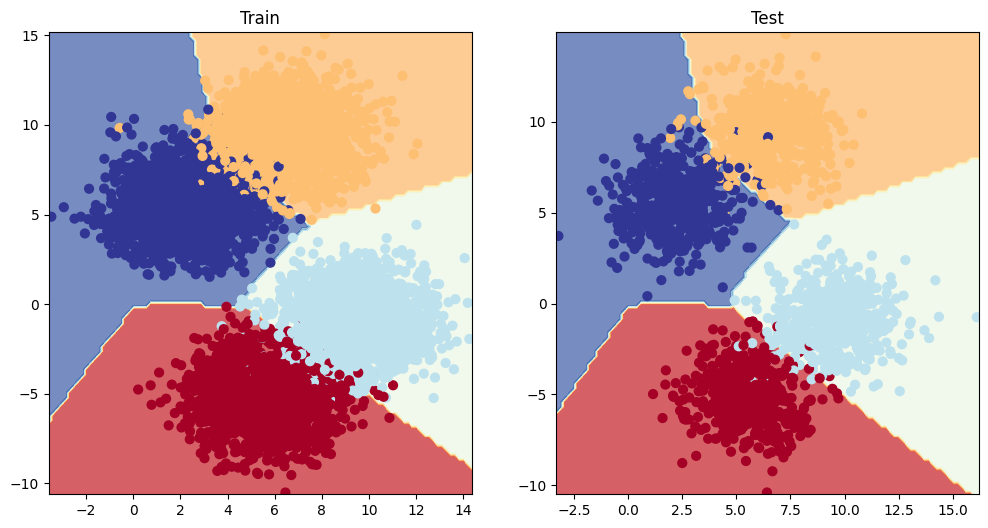

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)

#### Types of evaluation metrics
| Metric name/Evaluation method                                                               | Defintion                                                                                                                                                                      | Code                                                                                                                                    |
| ------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------- |
| Accuracy                                                                                    | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct.                                                      | torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()                                                                             |
| Precision                                                                                   | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).                         | torchmetrics.Precision() or sklearn.metrics.precision_score()                                                                           |
| Recall                                                                                      | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | torchmetrics.Recall() or sklearn.metrics.recall_score()                                                                                 |
| F1-score                                                                                    | Combines precision and recall into one metric. 1 is best, 0 is worst.                                                                                                          | torchmetrics.F1Score() or sklearn.metrics.f1_score()                                                                                    |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).                | torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()                                                                 |
| Classification report                                                                       | Collection of some of the main classification metrics such as precision, recall and f1-score.                                                                                  | [sklearn.metrics.classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |